# **MOUNT DRIVE AND INSTALL PACKAGE**

In [1]:
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CV-assignment

/content/drive/MyDrive/CV-assignment


# **IMPORT LIBRARIES**

In [4]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [5]:
import torch
import torchvision
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io,color
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
# For utilities
import os, shutil, time

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

2.1.0+cu121
True
1
0
Tesla T4


# **LOAD DATASETS**

Download Datasets Here: "https://www.kaggle.com/datasets/vitaliykinakh/stable-imagenet1k".
The data set has 1000 classes and each class has 100 pictures. I decide:
- Training set have 80k Image such that each class has 80 pictures.
- Test set have 20k Image such that each class has 80 pictures.tem

**INSTALL DATASETS**

In [11]:
path = os.path.abspath(os.getcwd())
train_color_dir = os.path.join(path,r"data/train_color")
test_color_dir = os.path.join(path,r"data/test_color")
train_gray_dir = os.path.join(path,r"data/train_gray")
test_gray_dir = os.path.join(path,r"data/test_gray")

In [34]:
transform_gray = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_color_CIFAR10=torchvision.datasets.CIFAR10(root=train_color_dir, train=True, download=True, transform=transform)
test_color_CIFAR10=torchvision.datasets.CIFAR10(root=test_color_dir,train=False, download=True, transform=transform)
train_gray_CIFAR10=torchvision.datasets.CIFAR10(root=train_gray_dir, train=True, download=True, transform=transform_gray )
test_gray_CIFAR10=torchvision.datasets.CIFAR10(root=test_gray_dir,train=False, download=True, transform=transform_gray )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [35]:
class PairedCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_gray, dataset_color):
        self.dataset_gray = dataset_gray
        self.dataset_color = dataset_color

    def __len__(self):
        return min(len(self.dataset_gray), len(self.dataset_color))

    def __getitem__(self, idx):
        img_gray, _ = self.dataset_gray[idx]
        img_color, _ = self.dataset_color[idx]
        return img_gray, img_color
train_dataset = PairedCIFAR10Dataset(train_gray_CIFAR10,train_color_CIFAR10)
test_dataset = PairedCIFAR10Dataset(test_gray_CIFAR10,test_color_CIFAR10)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# **COLOR IMAGE TO GRAYSCALE**

torch.Size([1, 32, 32]) torch.Size([3, 32, 32])


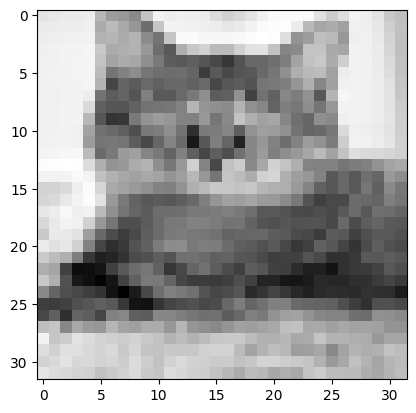

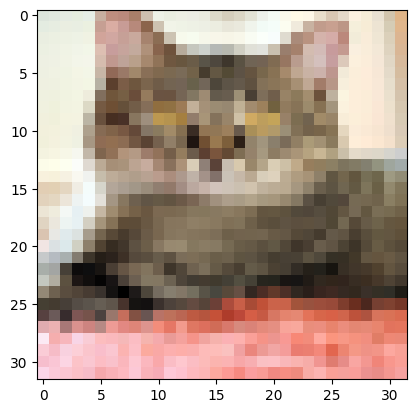

In [23]:
for batch in train_loader:
    images1, images2 = batch
    print(images1[0].shape,images2[0].shape)
    plt.imshow(images1[0].permute(1, 2, 0),cmap='gray')
    plt.show()
    plt.imshow(images2[0].permute(1, 2, 0))
    plt.show()
    break

# **GRAYSCALE TO COLOR IMAGE**

## **Parameter Settings**

In [24]:
num_epochs = 50
batch_size = 4
learning_rate = 1e-3
use_gpu = True

## **Build Model**

In [30]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1) # out: 1 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

cnet = ColorNet()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)
num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 774211


In [31]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)
cnet.train()
train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for i, data in enumerate(train_loader, 0):
        gray, color = data
        color = color.to(device)
        gray = gray.to(device)
        predict_color = cnet(gray)
        loss = F.mse_loss(predict_color,color)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.023773
Epoch [2 / 50] average reconstruction error: 0.016956
Epoch [3 / 50] average reconstruction error: 0.015383
Epoch [4 / 50] average reconstruction error: 0.014202
Epoch [5 / 50] average reconstruction error: 0.013269
Epoch [6 / 50] average reconstruction error: 0.012636
Epoch [7 / 50] average reconstruction error: 0.012064
Epoch [8 / 50] average reconstruction error: 0.011661
Epoch [9 / 50] average reconstruction error: 0.011347
Epoch [10 / 50] average reconstruction error: 0.010986
Epoch [11 / 50] average reconstruction error: 0.010698
Epoch [12 / 50] average reconstruction error: 0.010499
Epoch [13 / 50] average reconstruction error: 0.010285
Epoch [14 / 50] average reconstruction error: 0.010137
Epoch [15 / 50] average reconstruction error: 0.009935
Epoch [16 / 50] average reconstruction error: 0.009781
Epoch [17 / 50] average reconstruction error: 0.009593
Epoch [18 / 50] average reconstruction error: 0.009450
Epoch 

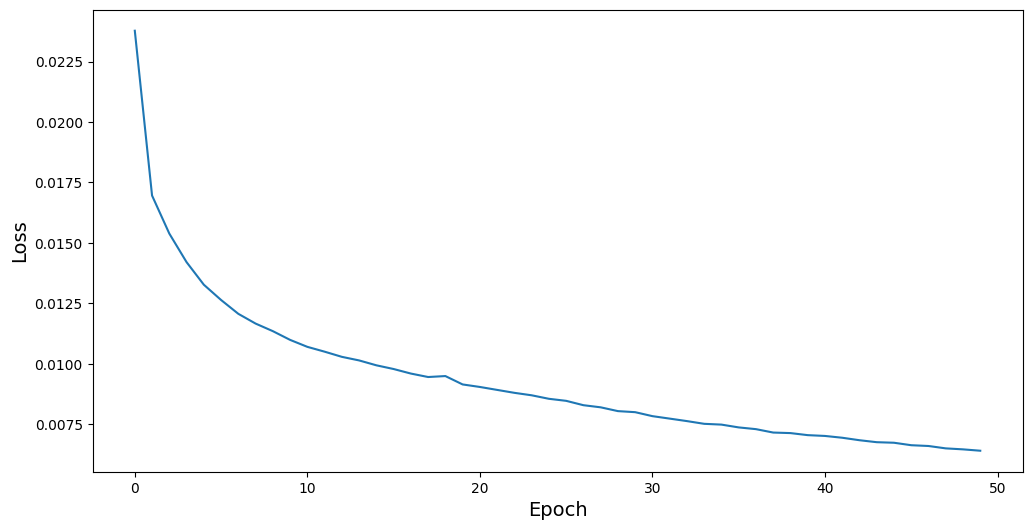

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(train_loss_avg))), train_loss_avg, label="loss")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

# **TESTING**

In [36]:
cnet.eval()
test_loss_avg, num_batches = 0, 0
for i, data in enumerate(test_loader, 0):
  with torch.no_grad():
      gray, color = data
      color = color.to(device)
      gray = gray.to(device)
      predict_color = cnet(gray)
      loss = F.mse_loss(predict_color,color)
      test_loss_avg += loss.item()
      num_batches += 1
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 0.005517


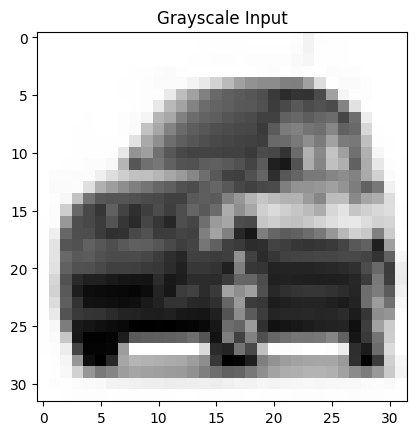

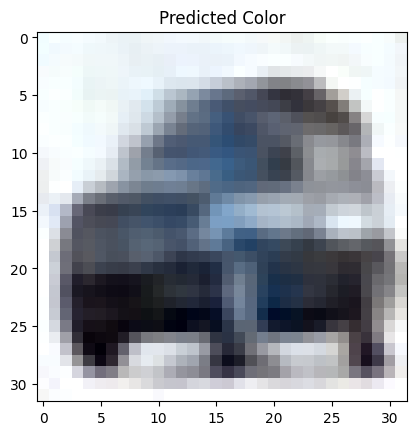

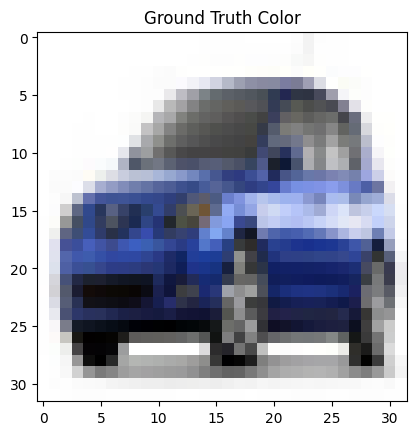

In [44]:
with torch.no_grad():
  for batch in test_loader:
        gray, color = batch
        gray = gray.to(device)  # Move input to the same device as the model
        color = color.to(device)  # Move target to the same device as the model

        predict_color = cnet(gray)

        # Move predictions back to CPU for visualization
        predict_color = predict_color.cpu()
        gray = gray.cpu()
        color = color.cpu()

        # Visualize the images
        plt.imshow(gray[0].permute(1, 2, 0), cmap='gray')
        plt.title('Grayscale Input')
        plt.show()

        plt.imshow(predict_color[0].permute(1, 2, 0))
        plt.title('Predicted Color')
        plt.show()

        plt.imshow(color[0].permute(1, 2, 0))
        plt.title('Ground Truth Color')
        plt.show()

        break  # Break after first batch for demonstration purposes